Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
dataset_path = '/content/sample_data/'
all_files = os.listdir(dataset_path)
dataframes = [pd.read_csv(dataset_path + file) for file in all_files if file.endswith('.csv')]

# Combine the dataset from multiple CSV files
data = pd.concat(dataframes, ignore_index=True)
data2=data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Idle Min,Label,0,0.1,0.2,0.3,0.4,0.5,0.6,Infilteration
0,22.0,6.0,23/02/2018 08:18:29,1532698.0,11.0,11.0,1179.0,1969.0,648.0,0.0,...,0.0,Benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,500.0,17.0,23/02/2018 08:17:45,117573855.0,3.0,0.0,1500.0,0.0,500.0,500.0,...,41990849.0,Benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,500.0,17.0,23/02/2018 08:17:45,117573848.0,3.0,0.0,1500.0,0.0,500.0,500.0,...,41990841.0,Benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,22.0,6.0,23/02/2018 08:19:55,1745392.0,11.0,11.0,1179.0,1969.0,648.0,0.0,...,0.0,Benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,500.0,17.0,23/02/2018 08:18:17,89483474.0,6.0,0.0,3000.0,0.0,500.0,500.0,...,7200485.0,Benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3210508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3210509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3210510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


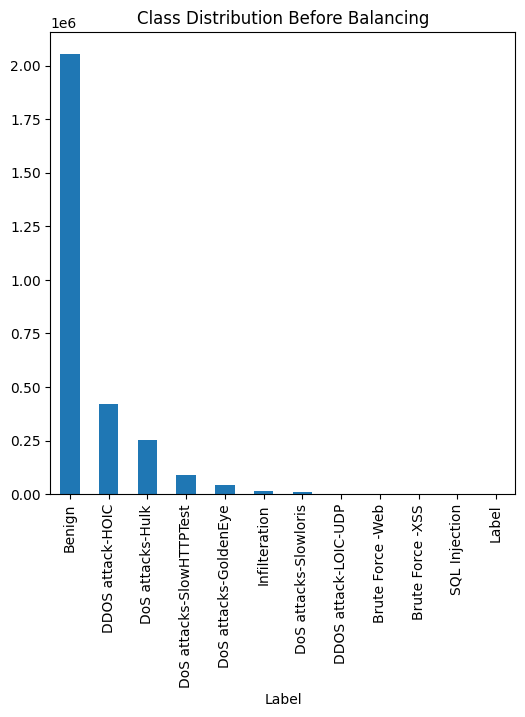

In [4]:
# Data Balancing
plt.figure(figsize=(6, 6))
data['Label'].value_counts().plot(kind='bar')
plt.title('Class Distribution Before Balancing')
plt.show()


In [ ]:
# Data cleaning: Remove NULL, Infinity, and Invalid values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Remove specific columns listed in Table III
columns_to_remove = [
    'Bwd PSH Flags', 'CWE Flag Count', 'Fwd URG Flags', 'Bwd URG Flags',
    'Fwd Byts/b Avg', 'Bwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Bwd Pkts/b Avg',
    'Fwd Blk Rate Avg', 'Bwd Blk Rate Avg'
]
data.drop(columns=columns_to_remove, axis=1, inplace=True)

# Convert attack labels to numeric values
attack_mapping = {
    'Benign': 0,
    'DDOS attack-HOIC': 1,
    'DoS attacks-Hulk': 2,
    'Bot': 3,
    'FTP-BruteForce': 4,
    'SSH-Bruteforce': 5,
    'DoS attacks-SlowHTTPTest': 6,
    'DoS attacks-GoldenEye': 7,
    'DoS attacks-Slowloris': 8,
    'DDOS attack-LOIC-UDP': 9,
    'Brute Force -Web': 10
}
data['Label'] = data['Label'].map(attack_mapping)



In [ ]:
# Identify non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns

# Convert non-numeric columns to numeric if applicable, otherwise drop
for col in non_numeric_cols:
    if col == 'Label':
        continue
    if pd.to_datetime(data[col], errors='coerce').notna().all():
        data[col] = pd.to_datetime(data[col]).astype(int) / 10**9  # Convert to UNIX timestamp
    else:
        data.drop(col, axis=1, inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data[data.columns[:-1]] = scaler.fit_transform(data[data.columns[:-1]])

# Split the dataset into features and labels
X = data.drop('Label', axis=1).values
y = data['Label'].values

In [ ]:
# Split the dataset into features and labels
X = data.drop('Label', axis=1).values
y = data['Label'].values



In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Stratified shuffle split to maintain class distribution
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes=11)
y_test = to_categorical(y_test, num_classes=11)

# Reshape data for CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Data balancing: Use the weights from Table II
class_weights = {
    0: 0.13,
    1: 0.97,
    2: 1.44,
    3: 2.32,
    4: 3.44,
    5: 3.55,
    6: 4.76,
    7: 16.00,
    8: 60.78,
    9: 385.93,
    10: 1087.56
}

In [ ]:
# Define the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(11, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_split=0.2, class_weight=class_weights)


Epoch 1/100
184/184 [==============================] - 5s 17ms/step - loss: 2.4463 - accuracy: 0.6411 - val_loss: 0.4423 - val_accuracy: 0.8881
Epoch 2/100
184/184 [==============================] - 2s 11ms/step - loss: 0.1772 - accuracy: 0.9027 - val_loss: 0.0774 - val_accuracy: 0.9846
Epoch 3/100
184/184 [==============================] - 2s 12ms/step - loss: 0.0751 - accuracy: 0.9767 - val_loss: 0.0475 - val_accuracy: 0.9895
Epoch 4/100
184/184 [==============================] - 2s 12ms/step - loss: 0.0498 - accuracy: 0.9854 - val_loss: 0.1288 - val_accuracy: 0.9789
Epoch 5/100
184/184 [==============================] - 2s 11ms/step - loss: 0.0404 - accuracy: 0.9819 - val_loss: 0.0510 - val_accuracy: 0.9912
Epoch 6/100
184/184 [==============================] - 2s 11ms/step - loss: 0.0320 - accuracy: 0.9865 - val_loss: 0.0680 - val_accuracy: 0.9895
Epoch 7/100
184/184 [==============================] - 2s 11ms/step - loss: 0.0208 - accuracy: 0.9914 - val_loss: 0.0355 - val_accuracy:

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}')

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
cm = confusion_matrix(y_test, y_pred_classes)
FP = cm.sum(axis=0) - np.diag(cm)
TN = cm.sum() - (FP + cm.sum(axis=1) - np.diag(cm))
FAR = FP / (FP + TN)
weighted_FAR = np.average(FAR, weights=np.sum(cm, axis=1))

# Handle single-class scenario in ROC AUC calculation
try:
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
except ValueError as e:
    print(f"ROC AUC calculation error: {e}")
    auc = None

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'False Alarm Rate (weighted): {weighted_FAR:.4f}')
if auc is not None:
    print(f'AUC: {auc:.4f}')
else:
    print("AUC: Calculation not possible due to missing class(es) in the test set")


920/920 [==============================] - 3s 3ms/step - loss: 0.0071 - accuracy: 0.9992
Test accuracy: 0.9992, Test loss: 0.0071
920/920 [==============================] - 2s 2ms/step
ROC AUC calculation error: Only one class present in y_true. ROC AUC score is not defined in that case.
Precision: 0.9992
Recall: 0.9992
F1 Score: 0.9992
AUC: Calculation not possible due to missing class(es) in the test set
